# Análisis de líneas espectrales estrellas masivas
***

* Las estrellas másivas son aquellas que tienen una masa superior a 8 masas solares.  Masa solar $≈  2 \times 10^{30}kg$, temperaturas $\geq 10.000 K$

* El análisis de estrellas masivas permite estudiar sus propiedades de pulsación y pérdida de masa, fundamentales para la comprensión de la evolución estelar y galáctica.

* Una tarea muy importante, es la estimación de parámetros estelares y de viento.

* Algunos de los parámetros estelares son: velocidad de rotación ($v sin i$), logaritmo de la gravedad ( $\log\,g$,), temperatura efectiva ($T_{\mathrm{eff}}$)

En este notebook se realizará un análisis simple para estimar $v sin i$,  $\log\,g$, y $T_{\mathrm{eff}}$


* Más sobre estrellas masivas en: https://massivestars.ifa.uv.cl/


## Ejemplo de línea espectral de estrella masiva observada
* Imagen obtenida del artículo: Arcos, C., Kanaan, S., Chávez, J., Vanzi, L., Araya, I., & Curé, M. (2018). Stellar parameters and H α line profile variability of Be stars in the BeSOS survey. Monthly Notices of the Royal Astronomical Society, 474(4), 5287-5299.  [Link](https://academic.oup.com/mnras/article/474/4/5287/4788120).

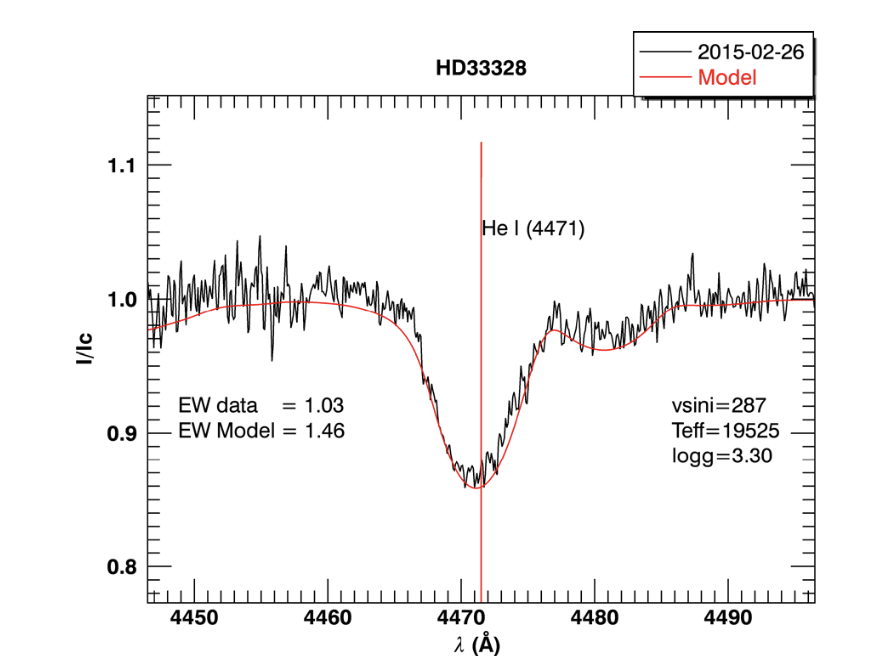

Longitud de onda vs intensidad de la luz

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
! pip install tensorflow_addons

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow_addons.metrics import RSquare
import numpy as np
import time

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Líneas espectrales sintéticas
***

* Acá, cargamos directamente un dataframe, generado por Daniela Turis, estudiante de Doctorado en Astrofísica (IFA-UV)
* El dataframe contiene 10691 líneas, y 188 columnas.
* Columnas con índice 0 a 169 corresponde a 169 puntos de flujos de la línea espectral
* Columnas con índice 170 a 175 son parámetros estelares de entrada
* Columnas con índice 176 a 179
y_input = df.iloc[:,170:176] # input parameters
y_output = df.iloc[:,176:] # output parameters

* Columnas con índice 176, 177 y 178: Teff, logg, vsini

## Datos:
* Se pueden descargar desde el directorio de Drive ubicado [acá](https://drive.google.com/drive/folders/1RP9mYlGoEXCaR0XemMH5LwWue8_buPpF?usp=sharing)

In [11]:
df = pd.read_csv("/content/gdrive/MyDrive/00_XAI_Curso/datos_XAI/df_ZPEKTR_limb_lineal.csv")

In [12]:
df[[ '<Teff>', '<logg>', 'vsini']]

,<Teff>,<logg>,vsini
0,25502.0,4.10,228.0
1,27478.0,4.16,309.0
2,18315.0,3.59,254.0
3,17238.0,4.07,351.0
4,20154.0,3.92,310.0
...,...,...,...
10686,17656.0,3.55,181.0
10687,26995.0,4.12,220.0
10688,20213.0,3.85,329.0
10689,20104.0,4.20,346.0


## Nota que solo predeciremos la temperatura efectiva

In [13]:
X = df.iloc[:,0:170] # X matrix containing spectral lines (flux)
y_input = df.iloc[:,170:176] # input parameters
y_output = df.iloc[:,176:] # output parameters
y = df.iloc[:,176:177] # y matrix containing the values we want to predict

In [14]:
y

,<Teff>
0,25502.0
1,27478.0
2,18315.0
3,17238.0
4,20154.0
...,...
10686,17656.0
10687,26995.0
10688,20213.0
10689,20104.0


## Gráfica de una línea espectral **sintética**

In [15]:
arr = X.columns.values.astype('float64')

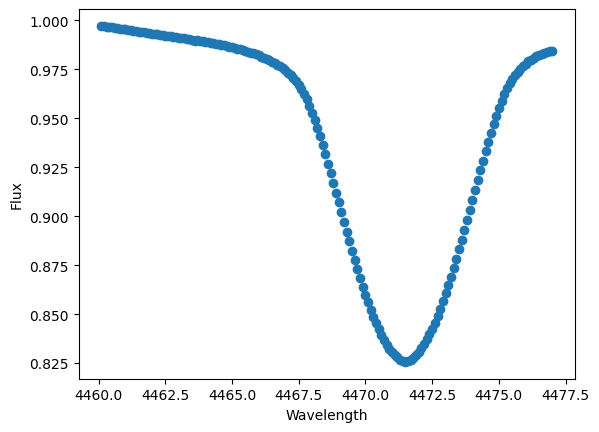

In [16]:
plt.figure()
plt.scatter(arr, X.iloc[2,:].values)
plt.xlabel("Wavelength")
plt.ylabel("Flux")
plt.show()




## Generación de datos de entrenamiento

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [18]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)


In [19]:
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

In [20]:
! pip install tensorflow_probability

In [21]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def NLL(y, distr):
  return -distr.log_prob(y)


In [22]:
%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.23.0
TF  Version 2.15.0


## Red Neuronal Probabilística

In [23]:
def normal_exp(params):
  return tfd.Normal(loc=params[:,0:1], scale=tf.math.exp(params[:,1:2]))# both parameters are learnable

In [24]:
inputs = Input(shape=(170,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(normal_exp, name='normal_exp')(params_mc)

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(learning_rate=0.002), loss=NLL)

In [25]:
model_mc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 170)]             0         
                                                                 
 dense (Dense)               (None, 200)               34200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               100500    
                                                                 
 dropout_1 (Dropout)         (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0     

In [ ]:
from time import time
start = time()

history = model_mc.fit(X_train, y_train, epochs=50, verbose=1,batch_size=64)
print('time taken : ',np.round(time() - start,3)) #468 sec

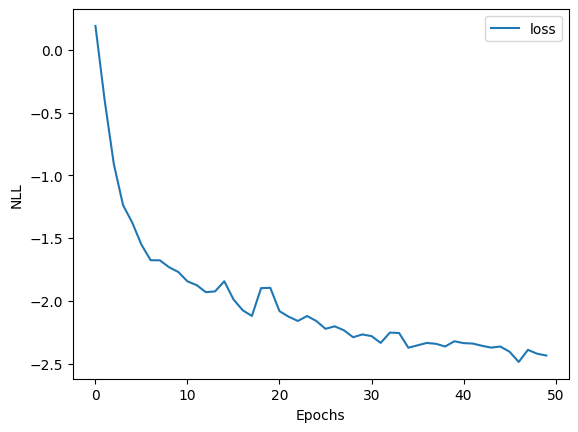

In [27]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
#plt.ylim([0,20])
plt.show()

In [ ]:
from tqdm import tqdm_notebook as tqdm
T = 100
mc_cpd =np.zeros((T,len(X_test)))
for i in tqdm(range(0,T)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(X_test),len(X_test))

In [34]:

X_test.shape

(2139, 170)

In [35]:
mc_cpd.shape

(100, 2139)

In [36]:
mc_cpd

array([[0.51816547, 0.3379429 , 0.58603442, ..., 0.41453144, 0.50015289,
        0.34435833],
       [0.52787238, 0.36381084, 0.59263855, ..., 0.36579278, 0.48047304,
        0.35757932],
       [0.52824646, 0.32359582, 0.52309924, ..., 0.4038063 , 0.4962219 ,
        0.37866625],
       ...,
       [0.54574096, 0.38515383, 0.57985014, ..., 0.40709203, 0.49729037,
        0.40393278],
       [0.51386058, 0.35245508, 0.56991172, ..., 0.40277225, 0.48599789,
        0.38458687],
       [0.52838707, 0.32998312, 0.58391994, ..., 0.34921581, 0.50420165,
        0.40184936]])

In [37]:
mc_cpd_mean = np.mean(mc_cpd,axis=0)

In [38]:
mc_cpd_mean.shape, y_test.shape

((2139,), (2139, 1))

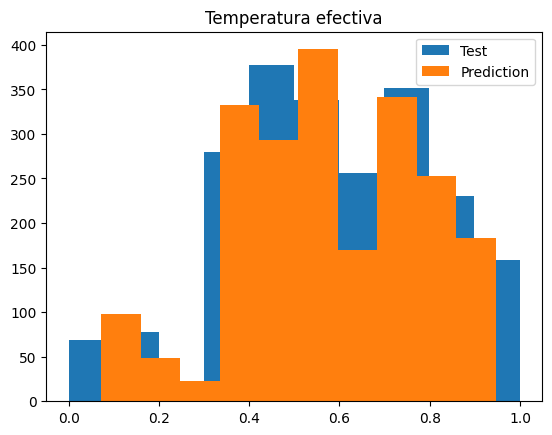

In [39]:
plt.figure()
plt.hist(y_test, label="Test")
plt.hist(mc_cpd_mean, label="Prediction")
plt.legend(loc="best")
plt.title("Temperatura efectiva")
plt.show()

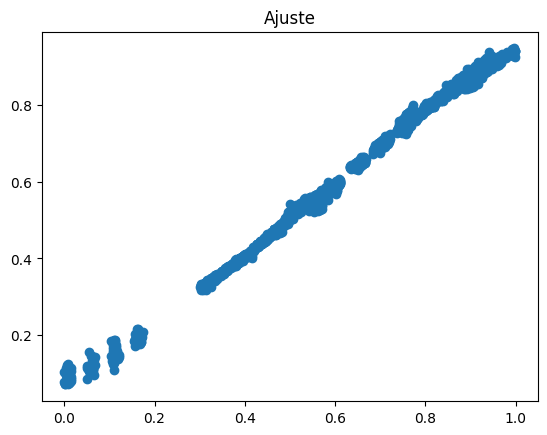

In [40]:
plt.figure()
plt.title("Ajuste")
plt.scatter(y_test,mc_cpd_mean)
plt.show()

## Preguntas

## Preguntas


1. En este notebook se está prediciendo la temperatura efectiva de la línea espectral ¿Qué enfoque específico para aproximar la red neuronal Bayesiana se está útilizando?
2. ¿La red está prediciendo directamente el valor de la temperatura efectiva? Argumente su respuesta.
3. ¿Qué hacen las sgtes. líneas de código?
4. El gráfico "Temperatura efectiva", ¿qué nos muestra? ¿Tiene sentido el rango de valores del eje x? Si considera que no, ¿cómo se debería modificar?
5. ¿Está bueno el ajuste mostrado en el gráfico "Ajuste"? ¿Cómo se puede medir ese ajuste cuantitativamente?


